Ce notebook vise à améliorer les performances de notre modèle de classification d'images médicales (radiographies pulmonaires) en appliquant une technique appelée fine-tuning sur le modèle pré-entraîné DenseNet121.


Le fine-tuning consiste à :

    Débloquer certaines couches du modèle pré-entraîné (ici DenseNet121) qui étaient gelées lors de l’entraînement initial.

    Réentraîner ces couches sur notre propre dataset médical pour que le modèle affine ses représentations et s’adapte aux spécificités des radiographies pulmonaires.

Cela permet d’augmenter la capacité d’adaptation du modèle, notamment pour des détails visuels très spécifiques à notre cas d’usage (ex. : motifs liés à la pneumonie).

Chargement du modèle DenseNet121 déjà entraîné (avec uniquement la tête personnalisée).

Déblocage progressif des couches profondes (haut du backbone).

Récompilation du modèle avec un taux d’apprentissage plus faible (pour éviter d’altérer brutalement les poids pré-entraînés).

Réentraîner le modèle sur les données d’entraînement et validation pendant quelques époques.

Enregistrement du nouveau modèle fine-tuné pour une évaluation ultérieure.

Pourquoi c'est important ? : 

Le modèle peut mieux capturer les motifs spécifiques aux radiographies pulmonaires.

Cela améliore la performance globale, notamment la précision et la généralisation.

C’est une étape clé pour tirer pleinement parti du transfert d’apprentissage avec des CNN pré-entraînés.

In [2]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Chemins
base_model_path = "models/densenet_model.keras"
finetuned_model_path = "models/densenet_model_finetuned.keras"
data_dir = Path("C:/WorkBench/Data/Projet/ZOIDBERG2.0/Travail/Data")
train_dir = data_dir / "train"
val_dir = data_dir / "val"

# Paramètres
img_size = (224, 224)
batch_size = 32
seed = 42

Utilisation du préchargement (prefetch) pour améliorer la performance lors de l'entraînement du modèle.

Importation du modèle DenseNet121 pré-entraîné sur ImageNet sans la couche de classification finale. Le modèle est gelé pour empêcher la mise à jour de ses poids durant la première phase d'entraînement.

In [3]:
# Charger le modèle gelé
model = load_model(base_model_path, compile=False)

# Recharger train/val datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size,
    seed=seed, label_mode='binary')
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size,
    seed=seed, label_mode='binary')

# Préfetch pour performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 4900 files belonging to 2 classes.
Found 1050 files belonging to 2 classes.


Ajout de la tête de classification personnalisée : pooling global, dropout pour réduire l'overfitting, et une couche dense avec une activation sigmoid pour la classification binaire.

In [ ]:
# Décongeler les X derniers blocs de DenseNet
base_model = model.layers[0]

for layer in base_model.layers[:]:
    layer.trainable = False

# On active l'entraînement des dernières couches
for layer in base_model.layers[-50:]:  
    layer.trainable = True

Compilation du modèle avec l'optimiseur Adam et la fonction de perte binaire. Entraînement du modèle pendant 5 époques avec uniquement la tête de classification (le backbone est gelé).

In [ ]:
# Compiler avec un learning rate faible
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
checkpoint = ModelCheckpoint(finetuned_model_path, save_best_only=True)

# Entraînement 
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop, checkpoint]
)



Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 589s 4s/step - accuracy: 0.6153 - loss: 1.2232 - val_accuracy: 0.8457 - val_loss: 0.3637
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 462s 3s/step - accuracy: 0.7628 - loss: 0.5746 - val_accuracy: 0.8981 - val_loss: 0.2795
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.8365 - loss: 0.4036 - val_accuracy: 0.9267 - val_loss: 0.2131
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 546s 4s/step - accuracy: 0.8737 - loss: 0.3332 - val_accuracy: 0.9286 - val_loss: 0.1882
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 528s 3s/step - accuracy: 0.8950 - loss: 0.2765 - val_accuracy: 0.9352 - val_loss: 0.1718


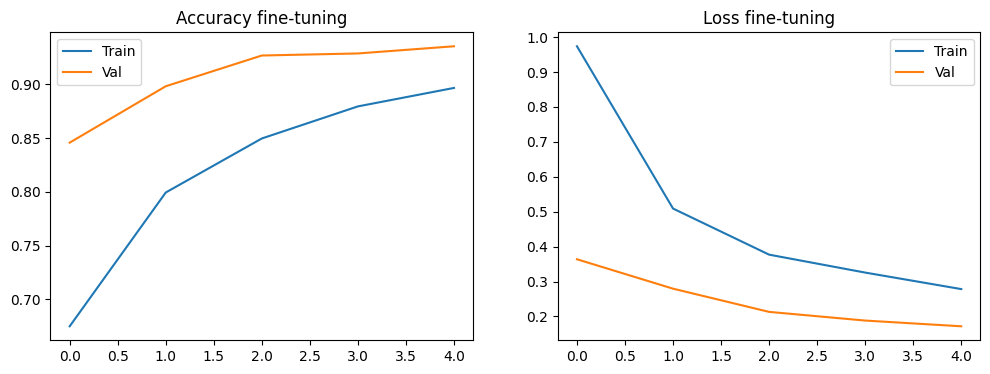

In [7]:
import matplotlib.pyplot as plt

# Tracer accuracy et loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_ft.history['accuracy'], label='Train')
plt.plot(history_ft.history['val_accuracy'], label='Val')
plt.title('Accuracy fine-tuning')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ft.history['loss'], label='Train')
plt.plot(history_ft.history['val_loss'], label='Val')
plt.title('Loss fine-tuning')
plt.legend()
plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# chemins
finetuned_model_path = "models/densenet_model_finetuned.keras"
data_dir = Path("C:/WorkBench/Data/Projet/ZOIDBERG2.0/Travail/Data")
test_dir = data_dir / "test"

# paramètres
img_size = (224, 224)
batch_size = 32
seed = 42

# rechargement
model_ft = load_model(finetuned_model_path, compile=False)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    label_mode='binary'
).prefetch(tf.data.AUTOTUNE)


Found 1050 files belonging to 2 classes.


In [11]:
# y_true
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# probabilités (classe 1 = pneumonia)
y_prob = model_ft.predict(test_ds, verbose=1).ravel()

# prédictions binaires (seuil 0.5)
y_pred = (y_prob >= 0.5).astype(int)


33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step


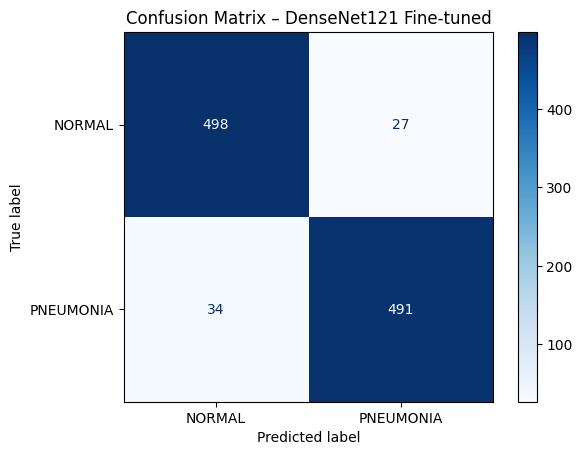

              precision    recall  f1-score   support

      NORMAL       0.94      0.95      0.94       525
   PNEUMONIA       0.95      0.94      0.94       525

    accuracy                           0.94      1050
   macro avg       0.94      0.94      0.94      1050
weighted avg       0.94      0.94      0.94      1050



In [12]:
# matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – DenseNet121 Fine-tuned")
plt.show()

# rapport de classification
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


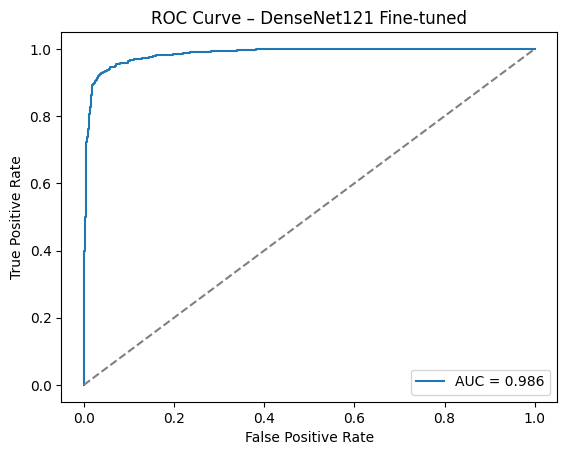

In [16]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – DenseNet121 Fine-tuned")
plt.legend(loc="lower right")
plt.show()